Total counts are 93983 counts
N^(1/3) = 45.465618272117574
Index(['ch1', 'dat1', 'ch2', 'dat2', 'cts_sec_pm', 'cts/sec'], dtype='object')




       ch1  dat1     ch2  dat2  cts_sec_pm   cts/sec
0        0     0     0.0     0     0.00000  0.000000
1        1     0     1.0     0     0.00000  0.000000
2        2     0     2.0     0     0.00000  0.000000
3        3     0     3.0     0     0.00000  0.000000
4        4     0     4.0     0     0.00000  0.000000
...    ...   ...     ...   ...         ...       ...
2043  2043   467  2043.0     4     0.00934  0.000046
2044  2044   505  2044.0     7     0.01010  0.000081
2045  2045   528  2045.0     7     0.01056  0.000081
2046  2046   522  2046.0     5     0.01044  0.000058
2047  2047   517  2047.0     4     0.01034  0.000046

[2048 rows x 6 columns]


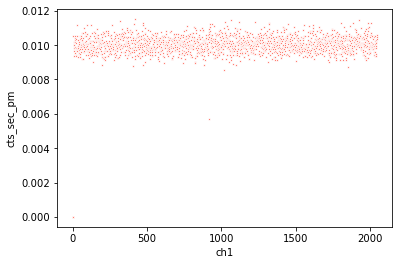

In [237]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize
from scipy.stats import norm
from scipy.stats import chisquare as Xsq
from astropy.io import ascii
from astropy.table import Table, vstack
import pandas as pd
from astropy import modeling
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import seaborn as sb

#Helper functions and data setup

txt_table = pd.read_csv('./Muon Lifetime/Muon_Lifetime.tsv',delim_whitespace=True,header=0)
txt_table.columns = ['ch1', 'dat1',
                    'ch2', 'dat2']
summary_data = Table.from_pandas(txt_table)

caldb_table = pd.read_csv('./Muon Lifetime/Calibration.tsv',delim_whitespace=True,header=1)
caldb_table.columns = ['ch1', 'dat1']
caldb_data = Table.from_pandas(caldb_table) 

print("Total counts are "+str(np.sum(txt_table['dat2']))+" counts")
print("N^(1/3) = "+str(np.sum(txt_table['dat2'])**(1/3)))

max_time = 86400 #seconds, but not going to use this this time
durations = [50000,86400]

#Normalize to counts/sec
txt_table['cts_sec_pm'] = txt_table['dat1']/durations[0]
txt_table['cts/sec'] = txt_table['dat2']/durations[1]

print(txt_table.columns)

print("\n\n\n")

print(txt_table)


sb.scatterplot(data=txt_table,x='ch1',y='cts_sec_pm',s=4,color="xkcd:salmon")

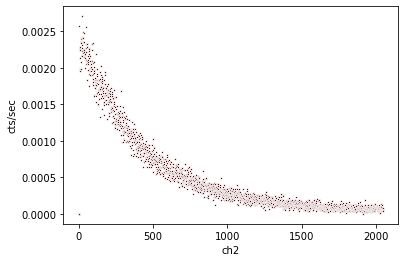

In [238]:
sb.scatterplot(data=txt_table,x='ch2',y='cts/sec',s=4,color="xkcd:dried blood")

In [165]:
#caldb linear fit, new x-axis stored in 'ts'
def t_by_channel(ch,A0,A_half,A1):
    return A0 + A_half*ch**0.5 + A1*ch

channels = caldb_table['ch1']
dts = caldb_table['dat1']
param_guesses = [0.0684,5e-4,4.9e-3]

params, covars = curve_fit(t_by_channel,channels,dts,param_guesses)
print(params)

[ 0.07200982 -0.00036848  0.00490815]


In [551]:
def t_by_channel_linear(ch,m,b):
    return m*ch+b

linefit = 0.0049005, 0.0684196

Power_divergenceResult(statistic=3.662742059653939e-05, pvalue=1.0)
[0.31  0.5   0.745 1.06  1.46  1.96  2.575 3.32  4.21  5.26  6.485 7.9  ]
[0.30773301 0.50056814 0.74838168 1.06056873 1.45902907 1.95916927
 2.57350887 3.32172239 4.20819509 5.26074001 6.48560387 7.899768  ]
[ 0.00226699 -0.00056814 -0.00338168 -0.00056873  0.00097093  0.00083073
  0.00149113 -0.00172239  0.00180491 -0.00074001 -0.00060387  0.000232  ]
[5.13922635e-06 3.22784676e-07 1.14357289e-05 3.23452246e-07
 9.42696481e-07 6.90106528e-07 2.22348028e-06 2.96664320e-06
 3.25771254e-06 5.47613383e-07 3.64659549e-07 5.38222698e-08]
[1.96115245 0.12317612 4.36392682 0.12343087 0.35973732 0.26334783
 0.84849032 1.13208471 1.24315811 0.20897179 0.13915576 0.02053883]
10.787170923092868
Data count = 12
1.1985745470103186
1.3278424039231227
4.069713399615487e-06
5.99689622696744e-06


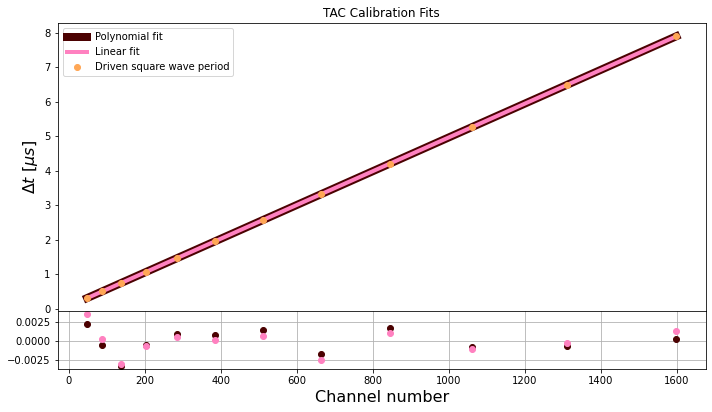

In [657]:
dts_np = np.array(dts)
dt_exp = np.array(t_by_channel(channels,0.07200982,-0.00036848,0.00490815))
dt_exp_line = np.array(t_by_channel_linear(channels,*linefit))
red_chisquare = Xsq(dts,dt_exp)
print(red_chisquare)

#err = .001791665
err = 0.0016188
errs = np.array([0.03,0.04,0.03,0.03,0.03,0.04,0.04,0.03,0.04,0.03,0.04,0.05])

print(dts_np)
print(dt_exp)
print(dts_np-dt_exp)
print((dts_np-dt_exp)**2)
print((dts_np-dt_exp)**2/(err**2))
print(np.sum((dts_np-dt_exp)**2/(err**2)))
print("Data count = "+str(len(dts)))
print((np.sum((dts_np-dt_exp)**2/(err**2)))/(len(dts)-3))
print((np.sum((dts_np-dt_exp_line)**2/(err**2)))/(len(dts)-2))

print((np.sum((dts_np-dt_exp)**2/(dt_exp)))/(len(dts)-3))
print((np.sum((dts_np-dt_exp_line)**2/(dt_exp_line)))/(len(dts)-2))


#PLOT
fig1 = plt.figure(1)
#Plot Data-model
frame1=fig1.add_axes((0.1,.3,1.5,1))
frame1.title.set_text("TAC Calibration Fits")
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(channels,dt_exp,'xkcd:dried blood',alpha=1,lw=8,label='Polynomial fit') #Best fit model
plt.plot(channels,dt_exp_line,'xkcd:pink',alpha=1,lw=4,label='Linear fit') #Best fit model, linear
plt.plot(channels,dts_np,'o',color='xkcd:pale orange',label='Driven square wave period') #Noisy data
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
#ax.set_xlabel(r'$\Delta$t [$\mu$s]',fontsize=16)
frame1.set_ylabel(r'$\Delta t$ [$\mu s$]',fontsize=16)
frame1.legend(loc=2)

#Residual plot
difference = dts_np-dt_exp
diff_line = dts_np-dt_exp_line
frame2=fig1.add_axes((.1,.1,1.5,.2))
frame2.plot(channels,difference,'o',color='xkcd:dried blood',label='Polynomial residuals')
frame2.plot(channels,diff_line,'o',color='xkcd:pink',label='Linear residuals')
frame2.set_xlabel('Channel number',fontsize=16)
frame2.grid(which="major")

In [656]:
print(np.std(dts_np-dt_exp))
print(np.std(dts_np-dt_exp_line))

print((0.0015348158048406+0.0017028466113)/2)

0.0015348158048406834
0.0017028466113754063
0.0016188312080703


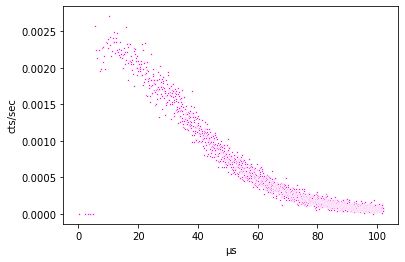

In [241]:
#Add a column with calibrated x values as ts

txt_table['μs'] = t_by_channel(txt_table['ch1'],*params)
sb.scatterplot(data=txt_table,x='μs',y='cts/sec',s=4,color="xkcd:fuchsia")

In [214]:
# Re-bin using pandas.cut
txt_table['μs_bins'] = pd.cut(txt_table['μs'],bins=119)
#txt_table['cts_bins'] = pd.cut(txt_table['cts/sec'],bins=16)

print(txt_table)

       ch1  dat1     ch2  dat2  cts_sec_pm   cts/sec         μs  \
0        0     0     0.0     0     0.00000  0.000000   0.072010   
1        1     0     1.0     0     0.00000  0.000000   0.076549   
2        2     0     2.0     0     0.00000  0.000000   0.081305   
3        3     0     3.0     0     0.00000  0.000000   0.086096   
4        4     0     4.0     0     0.00000  0.000000   0.090905   
...    ...   ...     ...   ...         ...       ...        ...   
2043  2043   467  2043.0     4     0.00934  0.000046  10.082708   
2044  2044   505  2044.0     7     0.01010  0.000081  10.087613   
2045  2045   528  2045.0     7     0.01056  0.000081  10.092517   
2046  2046   522  2046.0     5     0.01044  0.000058  10.097421   
2047  2047   517  2047.0     4     0.01034  0.000046  10.102325   

               μs_bins  
0       (0.062, 0.156]  
1       (0.062, 0.156]  
2       (0.062, 0.156]  
3       (0.062, 0.156]  
4       (0.062, 0.156]  
...                ...  
2043  (10.018, 10.10

In [215]:
#txt_table.groupby('μs_bins').mean()
binned_df = txt_table.groupby('μs_bins').agg({'cts/sec': [np.sum],'μs': [np.mean]})
#sb.scatterplot(data=binned_df,x='μs',y='cts/sec',s=4)

print(binned_df)

                   cts/sec         μs
                       sum       mean
μs_bins                              
(0.062, 0.156]    0.026308   0.112734
(0.156, 0.241]    0.040150   0.197751
(0.241, 0.325]    0.039769   0.283088
(0.325, 0.409]    0.035613   0.368531
(0.409, 0.493]    0.035058   0.451593
...                    ...        ...
(9.681, 9.765]    0.001030   9.724714
(9.765, 9.849]    0.001296   9.808082
(9.849, 9.934]    0.001516   9.891450
(9.934, 10.018]   0.001030   9.974819
(10.018, 10.102]  0.001204  10.060640

[119 rows x 2 columns]


In [216]:
binned_df.reset_index('μs_bins')

,μs_bins,cts/sec,μs
,,sum,mean
0,"(0.062, 0.156]",0.026308,0.112734
1,"(0.156, 0.241]",0.040150,0.197751
2,"(0.241, 0.325]",0.039769,0.283088
3,"(0.325, 0.409]",0.035613,0.368531
4,"(0.409, 0.493]",0.035058,0.451593
...,...,...,...
114,"(9.681, 9.765]",0.001030,9.724714
115,"(9.765, 9.849]",0.001296,9.808082
116,"(9.849, 9.934]",0.001516,9.891450


MultiIndex([('cts/sec',  'sum'),
            (     'μs', 'mean')],
           )


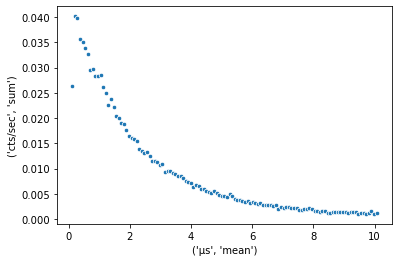

In [217]:
print(binned_df.columns)
sb.scatterplot(data=binned_df,x=('μs','mean'),y=('cts/sec','sum'),s=20)

                   cts/sec         μs  model_ts
                       sum       mean          
μs_bins                                        
(0.062, 0.156]    0.026308   0.112734  0.038965
(0.156, 0.241]    0.040150   0.197751  0.037526
(0.241, 0.325]    0.039769   0.283088  0.036136
(0.325, 0.409]    0.035613   0.368531  0.034796
(0.409, 0.493]    0.035058   0.451593  0.033543
...                    ...        ...       ...
(9.681, 9.765]    0.001030   9.724714  0.001065
(9.765, 9.849]    0.001296   9.808082  0.001046
(9.849, 9.934]    0.001516   9.891450  0.001028
(9.934, 10.018]   0.001030   9.974819  0.001011
(10.018, 10.102]  0.001204  10.060640  0.000993

[119 rows x 3 columns]
[4.04073569e-02 2.22682794e+00 5.52336552e-04]
[[ 3.19174602e-07 -1.66268103e-05 -4.85951781e-09]
 [-1.66268103e-05  4.91554154e-03 -1.50854107e-05]
 [-4.85951781e-09 -1.50854107e-05  7.36437469e-08]]


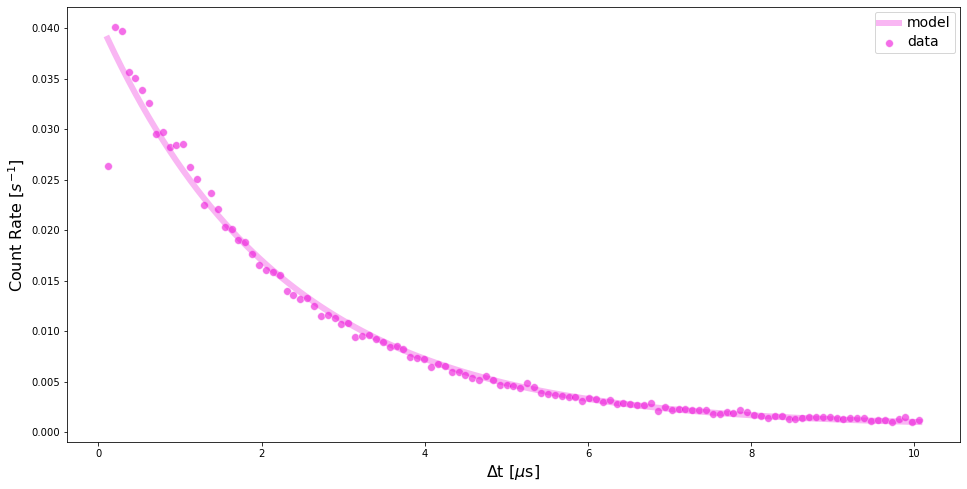

In [405]:
# curve_fit that
def expo_decay(t,A0,τ,y_offset):
    return y_offset + A0*np.exp(-t/τ)

params, covars = curve_fit(expo_decay,binned_df[('μs','mean')],binned_df[('cts/sec','sum')])

binned_df['model_ts'] = expo_decay(binned_df[('μs','mean')],*params)

#plt.plot(binned_df[('μs','mean')],model_ts)
a4_dims = (16, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sb.scatterplot(ax=ax,data=binned_df,x=('μs','mean'),y=('cts/sec','sum'),s=60,alpha=.6,color="xkcd:fuchsia",label="data")
sb.lineplot(ax=ax,data=binned_df,x=('μs','mean'),y=('model_ts'),alpha=0.3,lw=6,color="xkcd:fuchsia",label="model")
ax.set_xlabel(r'$\Delta$t [$\mu$s]',fontsize=16)
ax.set_ylabel(r'Count Rate [$s^{-1}]$',fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
print(binned_df)
print(params)
print(covars)

In [753]:


print(covars)

datay = np.array(binned_df[('cts/sec','sum')])
modely = np.array(binned_df['model_ts'])

dof = len(datay)-3
print("dof: "+str(dof))

print(datay)
print(modely)

#ChiSq = Xsq(datay,modely,3)

diffsq = np.square(np.subtract(datay,modely))
Xs = np.divide(diffsq,0.00125**2)
sumXs = np.sum(Xs)
red_Xs = sumXs/dof

print("dofs: "+str(dof))
print(diffsq)
print(sumXs)
print(red_Xs)

#print(ChiSq)

[[ 3.19174602e-07 -1.66268103e-05 -4.85951781e-09]
 [-1.66268103e-05  4.91554154e-03 -1.50854107e-05]
 [-4.85951781e-09 -1.50854107e-05  7.36437469e-08]]
dof: 116
[0.02630787 0.04015046 0.03976852 0.03561343 0.03505787 0.03392361
 0.03262731 0.02947917 0.0296875  0.02826389 0.02840278 0.02854167
 0.0262037  0.02505787 0.0225     0.02368056 0.0221412  0.02032407
 0.02008102 0.01902778 0.01886574 0.01765046 0.0165162  0.01608796
 0.01586806 0.01552083 0.01395833 0.01354167 0.01314815 0.01328704
 0.01251157 0.01150463 0.01157407 0.01127315 0.01071759 0.01083333
 0.00939815 0.00956019 0.00957176 0.00920139 0.00891204 0.00847222
 0.0084838  0.00820602 0.00746528 0.00731481 0.00722222 0.00642361
 0.00677083 0.00650463 0.00591435 0.00594907 0.00563657 0.0053125
 0.00517361 0.00560185 0.00513889 0.00471065 0.00462963 0.00452546
 0.00438657 0.00487269 0.00447917 0.00388889 0.00378472 0.00371528
 0.00356481 0.00344907 0.00349537 0.00310185 0.0033912  0.00328704
 0.00297454 0.00321759 0.00280093 

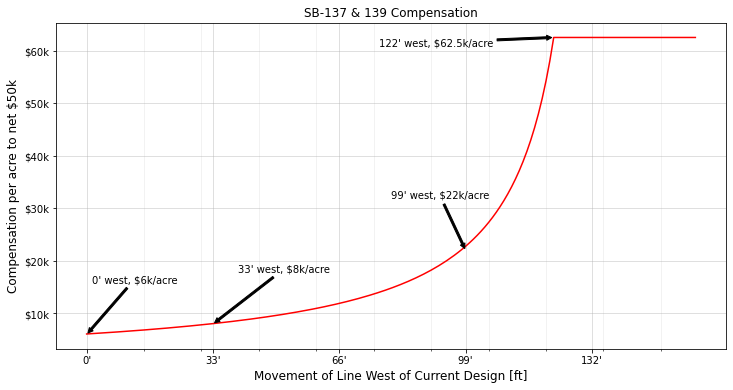

In [370]:
def comp(delta_x):
    max = 50/(0.8)
    change = ((122-delta_x)/16.5)
    rate = 50/(0.8+change)
    if change < 0:
        rate = max    
    return rate

xs = []
ys = []

xs = np.arange(0,160,1)
ys = [comp(x) for x in xs]

fig6, ax1 = plt.subplots(1,1,figsize=(12,6))#plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')

yformatter = ticker.FormatStrFormatter('$%1.0fk')
ax1.yaxis.set_major_formatter(yformatter)
xformatter = ticker.FormatStrFormatter('%1.0f\'')
ax1.xaxis.set_major_formatter(xformatter)
ax1.grid(which='both')

major_ticks = np.arange(0, 165, 33)
minor_ticks = np.arange(0, 165, 15)

ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)

ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)

ax1.annotate('0\' west, $6k/acre',
            xy=(0, 6), xycoords='data',
            xytext=(5, 50), textcoords='offset points',
            arrowprops=dict(arrowstyle='simple',facecolor='black'),
            horizontalalignment='left', verticalalignment='bottom')

ax1.annotate('33\' west, $8k/acre',
            xy=(33, 8), xycoords='data',
            xytext=(25, 50), textcoords='offset points',
            arrowprops=dict(arrowstyle='simple',facecolor='black'),
            horizontalalignment='left', verticalalignment='bottom')

ax1.annotate('99\' west, $22k/acre',
            xy=(99, 22), xycoords='data',
            xytext=(-75, 50), textcoords='offset points',
            arrowprops=dict(arrowstyle='simple',facecolor='black'),
            horizontalalignment='left', verticalalignment='bottom')

ax1.annotate('122\' west, $62.5k/acre',
            xy=(122, 62.5), xycoords='data',
            xytext=(-175, -10), textcoords='offset points',
            arrowprops=dict(arrowstyle='simple',facecolor='black'),
            horizontalalignment='left', verticalalignment='bottom')


ax1.plot(xs, ys, '-', color='red',label='Compensation rate')
ax1.title.set_text("SB-137 & 139 Compensation")
ax1.set_xlabel(r'Movement of Line West of Current Design [ft]',fontsize=12)
ax1.set_ylabel(r'Compensation per acre to net $50k',fontsize=12)

ax1.legend=1

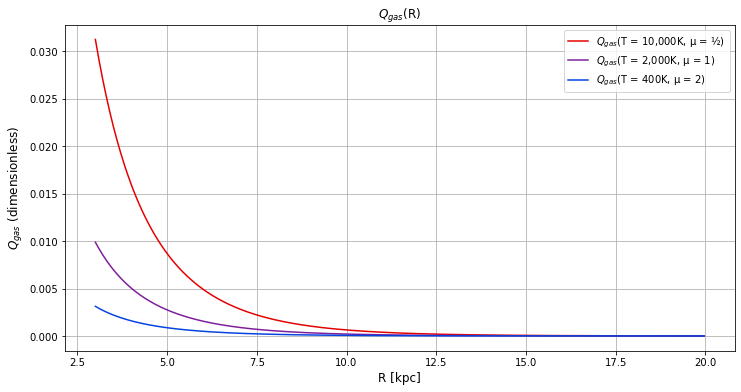

In [463]:
def Qgas(R,T,μ):
    return 2.1e-3*(1/R)*np.sqrt(T/(μ))*np.exp(-R/2.6)

points = 500
r_range = 3,20
Rs = np.arange(r_range[0],r_range[1],(r_range[1]-r_range[0])/500)

Ts = 10000,2000,400
μs = 0.5, 1, 2
colors = "xkcd:red","xkcd:purple","xkcd:blue"
labels = r"$Q_{gas}$(T = 10,000K, μ = ½)",r"$Q_{gas}$(T = 2,000K, μ = 1)",r"$Q_{gas}$(T = 400K, μ = 2)"

Qs = []

for inx in range(3):
    Qs.append(Qgas(Rs,Ts[inx],μs[inx]))
    
fig, ax2 = plt.subplots(1,1,figsize=(12,6))
ax2.grid(which='both')
for inx in range(len(Qs)):
    ax2.plot(Rs, Qs[inx], '-', color=colors[inx],label=labels[inx])
ax2.title.set_text(r"$Q_{gas}$(R)")
ax2.set_xlabel(r'R [kpc]',fontsize=12)
ax2.set_ylabel(r'$Q_{gas}$ (dimensionless)',fontsize=12)
#ax2.axhspan(0, 1, facecolor="xkcd:yellow", alpha=0.5,label="Region of instability")

#ax2.annotate('R = 9.07',
#            xy=(9.07, 1), xycoords='data',
#            xytext=(70, 60), textcoords='offset points',
#            arrowprops=dict(arrowstyle='simple',facecolor='black'),
#            horizontalalignment='left', verticalalignment='bottom')

#ax2.annotate('R = 6.82',
#            xy=(6.82, 1), xycoords='data',
#            xytext=(70, 60), textcoords='offset points',
#            arrowprops=dict(arrowstyle='simple',facecolor='black'),
#            horizontalalignment='left', verticalalignment='bottom')

#ax2.annotate('R = 4.76',
#            xy=(4.76, 1), xycoords='data',
#            xytext=(70, 60), textcoords='offset points',
#            arrowprops=dict(arrowstyle='simple',facecolor='black'),
#            horizontalalignment='left', verticalalignment='bottom')
#9.07, 6.82, 4.76

ax2.legend(loc=1)
#ax2.set_ylim(0,0.3)
plt.show()



In [440]:
def goal_seek(target,T,mu,_threshold):
    threshold = _threshold
    lower = 0
    upper = 100
    solve = (lower + upper)/2
    while abs(threshold) >= _threshold:
        print(f'Threshold is: {threshold}')
        print(f'range is: {lower}  ----  {solve}   ----   {upper}')
        if threshold < 0:
            upper = solve
            solve = (lower + upper)/2
        elif threshold > 0:
            lower = solve
            solve = (lower + upper)/2        
        threshold = target - Qgas(3,T,mu,solve)

    print(f'Final result: Threshold: {threshold}....Solved input: {solve}')
            
    return solve

In [449]:
from scipy.optimize import fsolve

def Qm1(R,T,mu):
    return Qgas(R,T,mu)-1

In [451]:
R1 = fsolve(Qm1,9.0,(10000,0.5))
print(R1)
print(Qgas(R1,10000,0.5))

R2 = fsolve(Qm1,6.0,(2000,1))
print(R2)

R3 = fsolve(Qm1,5.0,(400,2))
print(R3)

[9.07049977]
[1.]
[6.81896882]
[4.76013306]


In [493]:
v0 = 230 #km/s
v0_cgs = v0*1e5 #cm/s
r0 = 8.2 #kpc
r0_cgs = r0*3.1e21 #cm
c = 12
Rvir = 250 #km/s
Rs = Rvir/c
Rs_cgs = Rs*3.1e21 #cm
Gcgs = 6.67e-8

rho0 = (v0_cgs**2/(4*np.pi*Rs_cgs**3))*(1/((Gcgs/r0_cgs)*((1/(1+r0/Rs))+np.log(1+r0/Rs)-1)))

print(rho0)
print(Rs)
print(Rs_cgs)
print(v0_cgs)

1.2042375069489139e-24
20.833333333333332
6.458333333333333e+22
23000000.0


<ipython-input-519-3d5130b139de>:14: RuntimeWarning: divide by zero encountered in true_divide
  rho_r = rho0*(1/((r_cgs/Rs_cgs)*(1+r_cgs/Rs_cgs)**2))
<ipython-input-519-3d5130b139de>:8: RuntimeWarning: divide by zero encountered in true_divide
  v_cgs = np.sqrt(4*np.pi*rho*Rs_cgs**3*(Gcgs/r_cgs)*((1/(1+r_cgs/Rs_cgs))+np.log(1+r_cgs/Rs_cgs)-1))
<ipython-input-519-3d5130b139de>:8: RuntimeWarning: invalid value encountered in multiply
  v_cgs = np.sqrt(4*np.pi*rho*Rs_cgs**3*(Gcgs/r_cgs)*((1/(1+r_cgs/Rs_cgs))+np.log(1+r_cgs/Rs_cgs)-1))


Narrow avg = 299.39242205234655
Narrow stddev = 2.24471155247243
Peak = (array([141]), {})
45.12
301.7093759037304


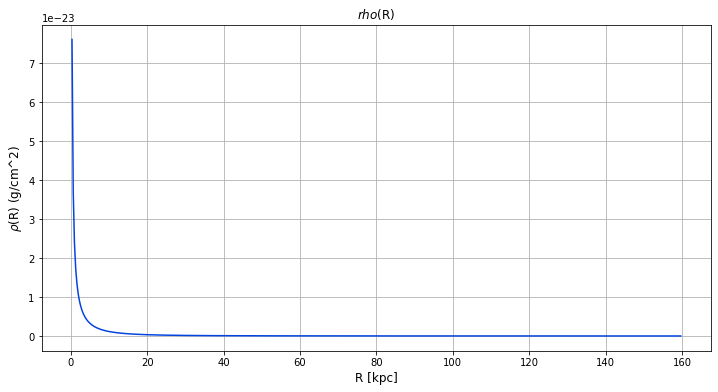

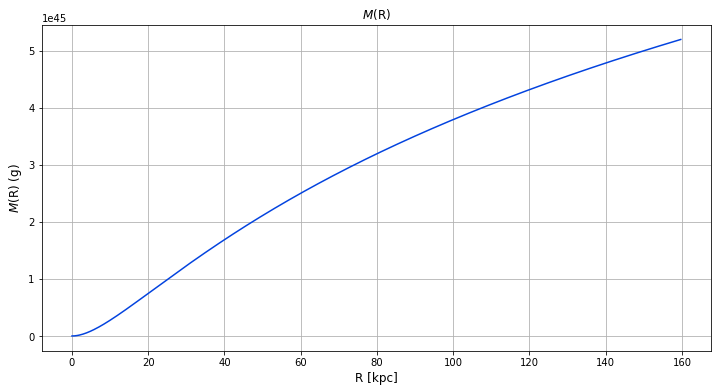

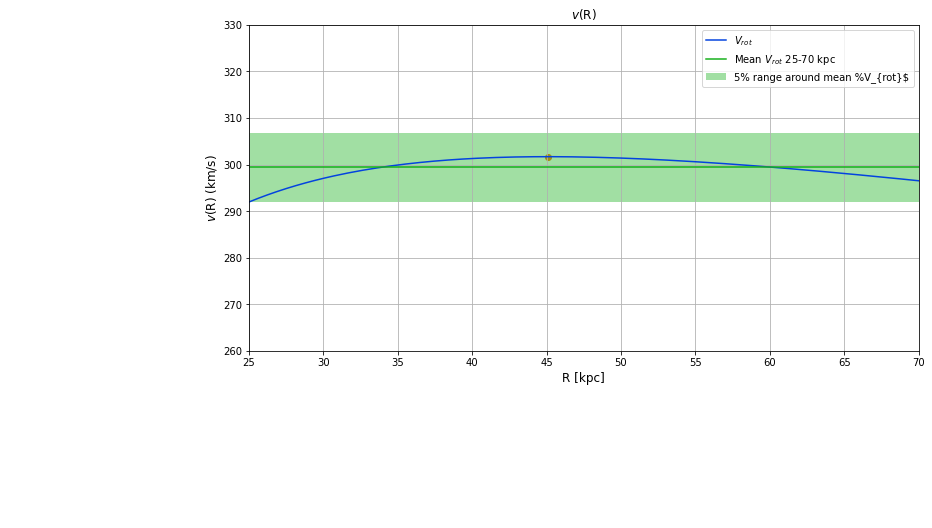

In [519]:
def M_r(r_kpc):
    r_cgs = r_kpc*3.1e21
    M_r = 4*np.pi*rho0*Rs_cgs**3*((1/(1+r_cgs/Rs_cgs))+np.log(1+r_cgs/Rs_cgs)-1)
    return M_r

def v_R(rho,Rs,r_kpc):
    r_cgs = r_kpc*3.1e21
    v_cgs = np.sqrt(4*np.pi*rho*Rs_cgs**3*(Gcgs/r_cgs)*((1/(1+r_cgs/Rs_cgs))+np.log(1+r_cgs/Rs_cgs)-1))
    v_kms = v_cgs/1e5
    return v_kms

def rho_r(r_kpc):
    r_cgs = r_kpc*3.1e21
    rho_r = rho0*(1/((r_cgs/Rs_cgs)*(1+r_cgs/Rs_cgs)**2))
    return rho_r

points = 500
r_range = 0,160
rs_kpc = np.arange(r_range[0],r_range[1],(r_range[1]-r_range[0])/points)
rs_cgs = rs_kpc*3.1e21

rhos = rho_r(rs_kpc)

ms = M_r(rs_kpc)
vs = v_R(rho0,Rs,rs_kpc)
narrow_vs = v_R(rho0,Rs,np.arange(25,70,0.1))
narrow_avg = np.mean(narrow_vs)
print("Narrow avg = "+str(np.mean(narrow_vs)))
narrow_std = np.std(narrow_vs)
print("Narrow stddev = "+str(narrow_std))

fig, ax5 = plt.subplots(1,1,figsize=(12,6))
ax5.grid(which='both')
ax5.plot(rs_kpc, rhos, '-', color=colors[inx],label=labels[inx])
ax5.title.set_text(r"$rho$(R)")
ax5.set_xlabel(r'R [kpc]',fontsize=12)
ax5.set_ylabel(r'$\rho$(R) (g/cm^2)',fontsize=12)           
#ax3.set_ylim(200,310)
                    
#plt.plot(rs_kpc,vs)
fig, ax3 = plt.subplots(1,1,figsize=(12,6))
ax3.grid(which='both')
ax3.plot(rs_kpc, ms, '-', color=colors[inx],label=labels[inx])
ax3.title.set_text(r"$M$(R)")
ax3.set_xlabel(r'R [kpc]',fontsize=12)
ax3.set_ylabel(r'$M$(R) (g)',fontsize=12)           
#ax3.set_ylim(200,310)

from scipy.signal import find_peaks

peak = find_peaks(vs)
print("Peak = " + str(peak))
print(rs_kpc[141])
print(vs[141])

fig, ax4 = plt.subplots(1,1,figsize=(12,6))
ax4.grid(which='both')
ax4.plot(rs_kpc, vs, '-', color=colors[inx],label=r'$V_{rot}$')
ax4.scatter(8.62,230)
ax4.scatter(45.12,301.7)
ax4.title.set_text(r"$v$(R)")
ax4.set_xlabel(r'R [kpc]',fontsize=12)
ax4.set_ylabel(r'$v$(R) (km/s)',fontsize=12)

ax4.annotate('R = 8.62 kpc, v = 230 km/s',
			xy=(8.62, 230), xycoords='data',
			xytext=(60, -30), textcoords='offset points',
			arrowprops=dict(arrowstyle='simple',facecolor='black'),
			horizontalalignment='left', verticalalignment='bottom')

#narrow_avg
ax4.axhline(narrow_avg,color="xkcd:green",label=r'Mean $V_{rot}$ 25-70 kpc')
ax4.axhspan(0.975*narrow_avg, 1.025*narrow_avg, facecolor="xkcd:green", alpha=0.4,label=r"5% range around mean %V_{rot}$")
# ax4.annotate('R = 45.12 kpc, v = 301 km/s',
# 			xy=(45.12, 301.7), xycoords='data',
# 			xytext=(0, -40), textcoords='offset points',
# 			arrowprops=dict(arrowstyle='simple',facecolor='black'),
# 			horizontalalignment='left', verticalalignment='bottom')
ax4.set_ylim(260,330)
ax4.set_xlim(25,70)
ax4.legend(loc=1)
plt.show()

Text(0, 0.5, '$R_s$, $R_{orb}$')

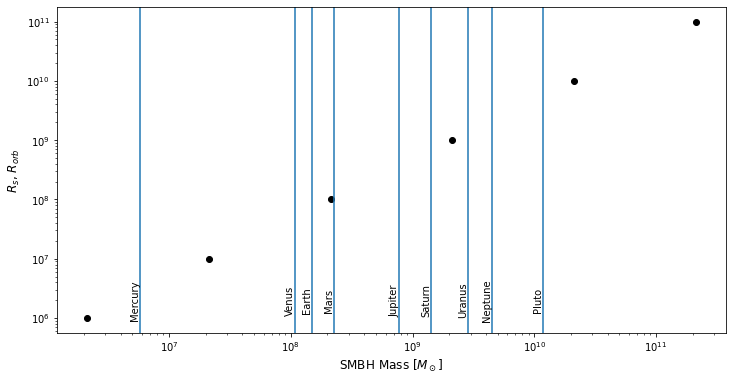

In [695]:
masses = [1e6,1e7,1e8,1e9,1e10,1e11]
distances = [2.12e6,2.12e7,2.12e8,2.12e9,2.12e10,2.12e11]
planets = ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]
plan_dists = [5.749e6,1.08e8,1.50e8,2.28e8,7.78e8,1.43e9,2.87e9,4.50e9,1.185e10]

fig, ax5 = plt.subplots(1,1,figsize=(12,6))
ax5.loglog(distances,masses,'ko')

for inx in range(len(planets)):
    ax5.axvline(plan_dists[inx],label=planets[inx])
    ax5.annotate(planets[inx],
            xy=(plan_dists[inx],2e6), xycoords='data',
            rotation=90,
            #xytext=(-175, -10), textcoords='offset points',
            #arrowprops=dict(arrowstyle='simple',facecolor='black'),
            horizontalalignment='right', verticalalignment='center')

ax5.set_xlabel(r'SMBH Mass [$M_\odot$]',fontsize=12)
ax5.set_ylabel(r'$R_s$, $R_{orb}$',fontsize=12)

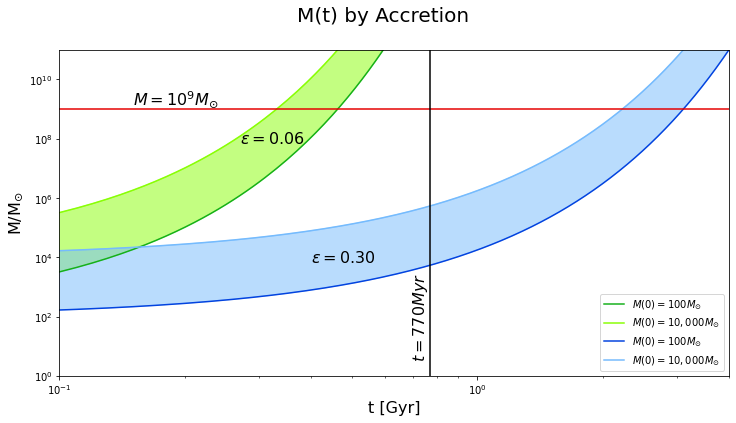

In [751]:
M0s = 100,10000 #M_suns
rad_effic = 0.06
t_Edd = 0.450 #Gyr

def M_t(t,M_0,epsilon,t_Edd):
    return (M_0*np.exp(((1-epsilon)/epsilon)*(t/t_Edd)))

times = np.arange(0,10,0.01)
M_ts_low = M_t(times,M0s[0],rad_effic,t_Edd)
M_ts_high = M_t(times,M0s[1],rad_effic,t_Edd)
M_ts_low2 = M_t(times,M0s[0],0.3,t_Edd)
M_ts_high2 = M_t(times,M0s[1],0.3,t_Edd)

fig, ax6 = plt.subplots(1,1,figsize=(12,6))
#ax6.grid(which='major')
ax6.loglog(times, M_ts_low, '-', color="xkcd:green",label=r"$M(0) = 100 M_{\odot}$")
ax6.plot(times, M_ts_high, '-', color="xkcd:lime green",label=r"$M(0) = 10,000 M_{\odot}$")
ax6.fill_between(times,M_ts_low,M_ts_high,color="xkcd:lime green",alpha=0.5)
ax6.annotate(r"$\epsilon = 0.06$",
            xy=(2.7e-1,1e8), xycoords='data',
            horizontalalignment='left', verticalalignment='center',fontsize=16)
ax6.annotate(r"$\epsilon = 0.30$",
            xy=(4e-1,1e4), xycoords='data',
            horizontalalignment='left', verticalalignment='center',fontsize=16)
ax6.annotate(r"$M = 10^9 M_{\odot}$",
            xy=(1.5e-1,1e9), xycoords='data',
            horizontalalignment='left', verticalalignment='bottom',fontsize=16)
ax6.annotate(r"$t = 770 Myr$",
            xy=(0.770,100), xycoords='data',
            horizontalalignment='right', verticalalignment='center', rotation=90,fontsize=16)
ax6.plot(times, M_ts_low2, '-', color="xkcd:blue",label=r"$M(0) = 100 M_{\odot}$")
ax6.plot(times, M_ts_high2, '-', color="xkcd:sky blue",label=r"$M(0) = 10,000 M_{\odot}$")
ax6.fill_between(times,M_ts_low2,M_ts_high2,color="xkcd:sky blue",alpha=0.5)
#ax6.title.set_text(r"M(t) by Accretion")
fig.suptitle(r"M(t) by Accretion", fontsize=20)
ax6.set_xlabel(r't [Gyr]',fontsize=16)
ax6.set_ylabel(r'M/M$_{\odot}$',fontsize=16)
ax6.axhline(1e9,color="xkcd:red")
ax6.axvline(0.770,color="xkcd:black")
ax6.set_ylim(1,1e11)
ax6.set_xlim(0.1,4e0)
ax6.legend(loc=4)